Linear Regression PySpark ML

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegressionExample") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

spark

In [ ]:
df = spark.read.csv("/content/Diabetes.csv", header=True, inferSchema=True)
df.show()
print(df.count())
print(df.rdd.getNumPartitions())

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+
|                 age|                 sex|                 bmi|                  bp|                  s1|                  s2|                  s3|                  s4|                  s5|                  s6|target|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+
|0.038075906433423026| 0.05068011873981862|0.061696206518683294|  0.0218723855140367|-0.04422349842444599|-0.03482076283769895|-0.04340084565202491|-0.00259226199818...|0.019907486170462722|-0.01764612515980379| 151.0|
|-0.00188201652779...|-0.04464163650698...|-0.05147406123880...|-0.02632752814785296|-0.00844872411121...|-0.01916333974822.

In [ ]:
df = df.repartition(4)
df.rdd.getNumPartitions()

4


StringIndexer

In [ ]:
# This step is only needed if I have string in my data. In this example, it is not needed this step.
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = 'sex', outputCol = 'gender')

df = indexer.fit(df).transform(df)

df.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+------+
|                 age|                 sex|                 bmi|                  bp|                  s1|                  s2|                  s3|                  s4|                  s5|                  s6|target|gender|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+------+
| 0.03081082953138418| 0.05068011873981862| 0.05954058237092167|0.056300895272529315|-0.02220825269322806|0.001191310268097...|-0.03235593223976409|-0.00259226199818...|-0.02479542902879...|-0.01764612515980379| 263.0|   1.0|
|0.005383060374248237| 0.05068011873981862| 0.03475090467166331|-0.00109143049487...| 0.15253776

Vector Assembler

In [ ]:
assembler = VectorAssembler(inputCols = ["age", "gender", "bmi","bp","s1","s2","s3","s4","s5","s6"],
                            outputCol = 'features')

data = assembler.transform(df)

data = data.select('features', 'target')
data.show(5, truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                                                                                                              |target|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[0.03081082953138418,1.0,0.05954058237092167,0.056300895272529315,-0.02220825269322806,0.0011913102680975625,-0.03235593223976409,-0.002592261998183278,-0.024795429028792802,-0.01764612515980379]   |263.0 |
|[0.005383060374248237,1.0,0.03475090467166331,-0.0010914304948778783,0.15253776029831428,0.19878798965729408,-0.06180903467245962,0.18523444326019867,0.015568459328120

StandardScaler

In [ ]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')
#scaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaledFeatures')

scaler_model = scaler.fit(data) # compute the mean & std from data and store the necessary scaling parameters.
data = scaler_model.transform(data) # scale the features of rhe sata using parameteres learned during fit() step

data = data.select('scaledFeatures', 'target')
data.show(5, truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|scaledFeatures                                                                                                                                                                                       |target|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[0.6470274201590677,2.001756860182961,1.250352229789355,1.1823188007231162,-0.46637330655778964,0.0250175156300488,-0.6794745770350461,-0.054437501961848836,-0.5207040096046488,-0.3705686283558794]|263.0 |
|[0.11304426785921295,2.001756860182961,0.7297689981049295,-0.022920040392435455,3.203292966264603,4.174547782803174,-1.2979897281216526,3.889923308464172,0.326937645890533

In [ ]:
# split data
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 42)
train_data.show(5, truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|scaledFeatures                                                                                                                                                                                           |target|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[-2.0991716488116134,0.0,-1.4204660892872656,-2.2880749829329408,-1.5643836874022852,-1.5269462609988855,0.32561254348068924,-0.8293610403559591,-1.0473214879847859,-0.19660013793283235]               |55.0  |
|[-2.0991716488116134,0.0,-0.4924698936758978,-1.3481766665260921,-1.2176435671356023,-1.263901553095676,0.2482981495948635,-0.8293610403559591,-0.380387538

Apply linear regression model

In [ ]:
lr = LinearRegression(labelCol = 'target', featuresCol = 'scaledFeatures', predictionCol = 'prediction')

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Make prediction on the test data
lr_predictions = lr_model.transform(test_data)

In [ ]:
ions = lr_model.transform(test_data)

lr_predictions.select('prediction', 'target').show(10, truncate = False)

+------------------+------+
|prediction        |target|
+------------------+------+
|67.12110314601263 |200.0 |
|192.7423586745321 |68.0  |
|181.58426538411305|200.0 |
|65.80594631152965 |104.0 |
|33.29544431309452 |45.0  |
|282.6992948134958 |243.0 |
|158.430847415866  |200.0 |
|127.63829493372486|214.0 |
|88.99688473487011 |118.0 |
|117.86081917496494|64.0  |
+------------------+------+
only showing top 10 rows



In [ ]:
# Access the coefficients and intecept of the model
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(coefficients)
print(intercept)

[1.2214376408050633,-11.985375458124867,28.415632881896325,17.51561909802755,-51.16866117438874,30.06179259358891,14.582707069012333,13.8680345082736,40.79635410600757,0.5216358782017909]
164.78843731752943


Apply Lasso and Ridge regression models

In [ ]:
# Laaso
lasso = LinearRegression(labelCol = 'target', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 1.0, regParam = 0.15) # lambda: tuning
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)

# Ridge
ridge = LinearRegression(labelCol = 'target', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 0.0, regParam = 0.15) # lambda: tuning
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

In [ ]:
lasso_predictions.select('prediction', 'target').show(10, truncate = False)

+------------------+------+
|prediction        |target|
+------------------+------+
|71.30744307647234 |200.0 |
|192.70558974574553|68.0  |
|185.62323331532   |200.0 |
|64.82264987752184 |104.0 |
|35.97282101201796 |45.0  |
|282.7087447133871 |243.0 |
|158.32414684098097|200.0 |
|124.84870704287606|214.0 |
|90.60911265351469 |118.0 |
|114.47403210631154|64.0  |
+------------------+------+
only showing top 10 rows



Evaluate the models and visualize the results

In [ ]:
evaluator_mse = RegressionEvaluator(labelCol = 'target', predictionCol = 'prediction', metricName = 'mse')
# calculate MSE
mse1 = evaluator_mse.evaluate(lr_predictions)
mse2 = evaluator_mse.evaluate(lasso_predictions)
mse3 = evaluator_mse.evaluate(ridge_predictions)

evaluator_rmse = RegressionEvaluator(labelCol = 'target', predictionCol = 'prediction', metricName = 'rmse')
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(lr_predictions)
rmse2 = evaluator_rmse.evaluate(lasso_predictions)
rmse3 = evaluator_rmse.evaluate(ridge_predictions)

evaluator_r2 = RegressionEvaluator(labelCol = 'target', predictionCol = 'prediction', metricName = 'r2')
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(lr_predictions)
r2_score2 = evaluator_r2.evaluate(lasso_predictions)
r2_score3 = evaluator_r2.evaluate(ridge_predictions)

In [ ]:
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mse2, ', RMSE: ', rmse2, ', R^2: ', r2_score2)
print('Ridge - MSE: ', mse3, ', RMSE: ', rmse3, ', R^2: ', r2_score3)

Regression - MSE:  2946.620303289265 , RMSE:  54.28278090968871 , R^2:  0.39052179050136215
Lasso - MSE:  2914.732843862849 , RMSE:  53.98826579788287 , R^2:  0.39711738466562474
Ridge - MSE:  2934.3433756845902 , RMSE:  54.16957979977868 , R^2:  0.393061147148803


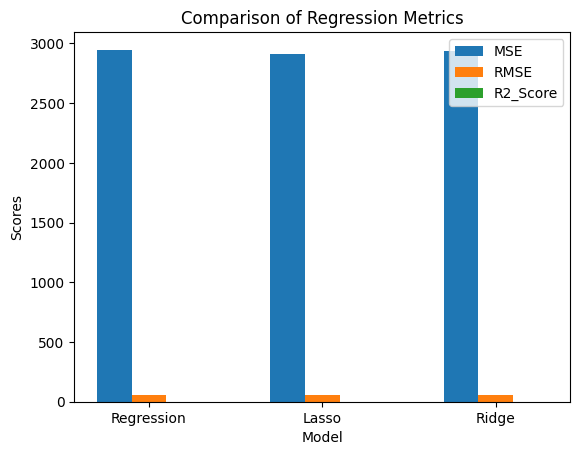

In [ ]:

# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mse2, mse3]
rmse = [rmse1, rmse2, rmse3]
r2_score = [r2_score1, r2_score2, r2_score3]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()